# Examples of configuring and running NSGA-II

This notebook includes examples where the NSGA-II algorithm is used to solve continuous and binary multi-objective problems. 

There are two basic ways of using NSGA-II with MetaJul. The first one is using the `EvolutionaryAlgorithm` struct, which must be populated with specific components characterizing NSGA-II, and the second one is based on the `NSGAII` struct, which constitutes a simpler way to obtain a standard NSGA-II but it does not offer the wide range of alternatives for setting up NSGA-II variants as the first option. We include in this notebook examples of both schemes in the notebook, starting by the second approach.

In [2]:
using MetaJul

## Configure NSGA-II to solve a continuous problem (Kursawe) using default settings

The first step is to instantiate the problem to be solve. In this case, we choose the classical Kursawe continuous problem.

In [4]:
problem = kursawe() ;

The settings of NSGA-II for continuous, used in many studies, are the following:
``` Julia
populationSize = 100
mutation = PolynomialMutation(probability = 1.0/numberOfVariables(problem), distributionIndex = 20.0, bounds = problem.bounds)
crossover = SBXCrossover(probability = 1.0, distributionIndes = 20.0, bounds = problem.bounds)
termination = TerminationByEvaluations(25000)
```

so, to optimize the problem with NSGA-II, we only need to call the NSGA-II function:

In [5]:
solver= NSGAII(problem);

Then we can run the algorithm and plot the results:

In [6]:
optimize!(solver)

println("Computing time: ", computingTime(solver))

Computing time: 2052 milliseconds


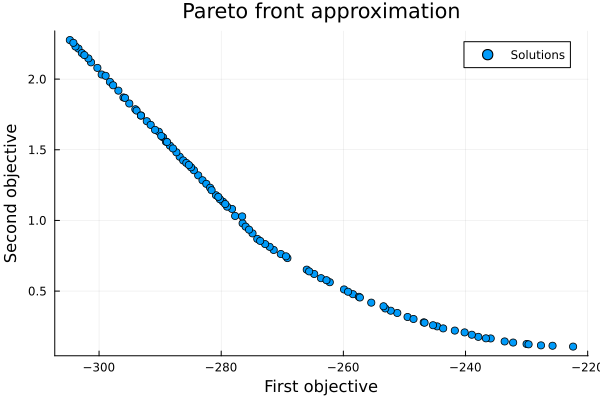

In [7]:
using Plots
 
#data to plot
x = [solution.objectives[1] for solution in foundSolutions(solver)];
y = [solution.objectives[2] for solution in foundSolutions(solver)];
 
gr();
 
scatter(x, y,  title = "Pareto front approximation", label = "Solutions")
xlabel!("First objective")
ylabel!("Second objective")

## Configure NSGA-II to solve a continuous problem (Kursawe) using specific settings
If we prefer to explicitly set the settings, we can do it in this way:

In [8]:
mutation = UniformMutation(probability = 1.0/numberOfVariables(problem), perturbation = 0.5, bounds = problem.bounds)
crossover = BLXAlphaCrossover(probability = 1.0, alpha = 0.5, bounds = problem.bounds)
termination = TerminationByEvaluations(25000)

nsgaII::NSGAII = NSGAII(problem, populationSize=50,termination=termination, mutation=mutation, crossover=crossover) ;

We run NSGA-II with the new settings and plot the obtained front

In [9]:
optimize!(nsgaII)

println("Computing time: ", computingTime(nsgaII))

Computing time: 881 milliseconds


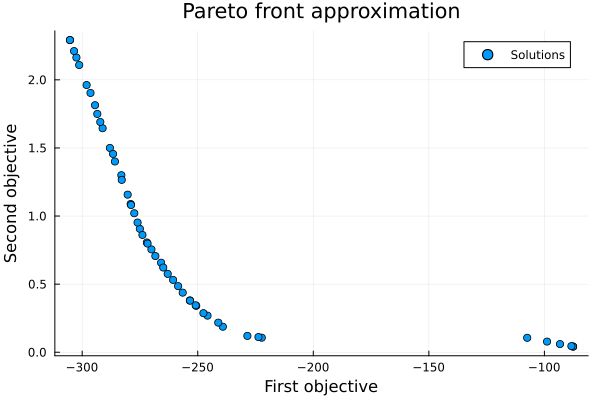

In [10]:
 #data to plot
x = [solution.objectives[1] for solution in foundSolutions(nsgaII)];
y = [solution.objectives[2] for solution in foundSolutions(nsgaII)];
 
gr();
 
scatter(x, y,  title = "Pareto front approximation", label = "Solutions")
xlabel!("First objective")
ylabel!("Second objective")

## Configure the algorithm to solve a binary problem using default setings (OneZeroMax)

In [9]:
# The oneZeroMax function consists of miximizing the number of zeros and the number of ones in a binary string
numberOfBits = 512
problem = oneZeroMax(numberOfBits) ;

The default settings for NSGA-II to solve binary problems are:
``` Julia
populationSize = 100, 
termination = TerminationByEvaluations(25000),
mutation = BitFlipMutation(probability = 1.0 / problem.numberOfBits),
crossover = SinglePointCrossover(probability = 1.0)
```

Consequently, the steps for creating and running the algorithm and plotting the found front are:

In [10]:
solver = NSGAII(problem) ;

In [11]:
optimize!(solver)

println("Computing time: ", computingTime(solver)) ;

Computing time: 1929 milliseconds


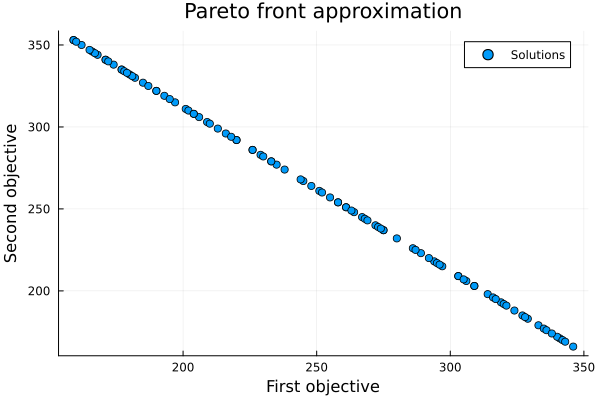

In [12]:
# data to plot
x = [solution.objectives[1] for solution in foundSolutions(solver)];
y = [solution.objectives[2] for solution in foundSolutions(solver)];
 
gr();
 
scatter(x, y,  title = "Pareto front approximation", label = "Solutions")
xlabel!("First objective")
ylabel!("Second objective")

## Configure the algorithm to solve a binary problem using specific setings (OneZeroMax)
We give now an example of configuring NSGA-II with specific settings:

In [13]:
termination = TerminationByEvaluations(10000)
mutation = BitFlipMutation(probability = 1.0 / problem.numberOfBits)
crossover = SinglePointCrossover(probability = 0.9)

solver::NSGAII = NSGAII(problem, populationSize=50,termination=termination, mutation=mutation, crossover=crossover) ;

ErrorException: cannot set type for global Main.solver. It already has a value or is already set to a different type.

In [14]:
optimize!(solver)

println("Computing time: ", computingTime(solver))

Computing time: 1387 milliseconds


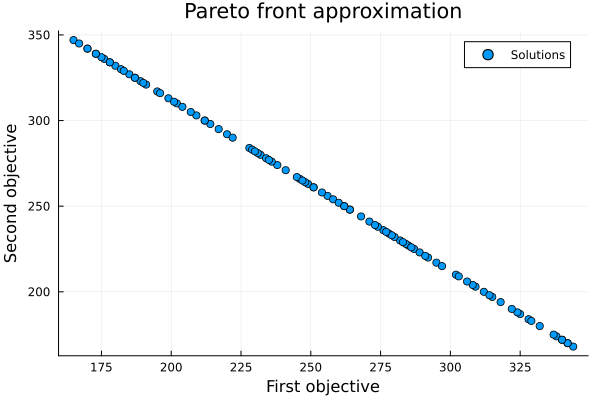

In [15]:
# data to plot
x = [solution.objectives[1] for solution in foundSolutions(solver)];
y = [solution.objectives[2] for solution in foundSolutions(solver)];
 
gr();
 
scatter(x, y,  title = "Pareto front approximation", label = "Solutions")
xlabel!("First objective")
ylabel!("Second objective")

## Configure NSGA-II with by using the `EvolutionaryComputation` struct

The definition of the `NSGA-II` struct contains a field called `solver` that is of type `EvolutionaryAlgorithm`, which is an approach that can be adopted to simulate, to some extent, object-orientation in Julia. However, we can directly use the `EvolutionaryAlgorithm` struct to create a NSGA-II algorithm. This scheme which requires to create all the components characterizing NSGA-II, but it has the advantage of allowing a higher flexibility grade (see the example notebooks to incorporate external archives to NSGA-II). 

In [16]:
problem = ZDT2() ;

### Step 1: creating the evolutionary algorithm struct

In [17]:
nsgaII::EvolutionaryAlgorithm = EvolutionaryAlgorithm()
nsgaII.name = "NSGA-II" ;

ErrorException: cannot set type for global Main.nsgaII. It already has a value or is already set to a different type.

### Step 2: specifying the population size and offspring population sizes
NSGA-II is, by default, a generational evolutionary algorithm, but a steady-state version can be instatiated by using an offspring population size of 1.

In [18]:
populationSize = 100
offspringPopulationSize = 100 ; # Use 1 for a steady-state version.

### Step 3: creating the `SolutionsCreation`, `Evaluation`, and `Termination` components:

In [19]:
nsgaII.solutionsCreation = DefaultSolutionsCreation(problem, populationSize)
nsgaII.evaluation = SequentialEvaluation(problem)
nsgaII.termination = TerminationByEvaluations(25000) ;

ErrorException: type NSGAII has no field solutionsCreation

### Step 4: creating the `Variation` components from the crossover and mutation operators
The `Variation` components requiere to know the offspring population size to compute the matting pool size (i.e., the number of parents that the `Selection` component must produce), which depends directly on the n-arity of the crossover operator.

In [20]:
mutation = PolynomialMutation(probability = 1.0 / numberOfVariables(problem), distributionIndex = 20.0, bounds = problem.bounds)
crossover = SBXCrossover(probability = 0.9, distributionIndex = 20.0, bounds = problem.bounds)

nsgaII.variation = CrossoverAndMutationVariation(offspringPopulationSize, crossover, mutation) ;

ErrorException: type NSGAII has no field variation

### Step 5: creating the `Selection` component
The default selection in NSGA-II is binary tournament:

In [21]:
nsgaII.selection = BinaryTournamentSelection(nsgaII.variation.matingPoolSize, DefaultDominanceComparator());

ErrorException: type NSGAII has no field variation

### Step 6: creating the `Replacement` component 
The main feature of NSGA-II is a replacement step that joins the population and the offspring population, sorts the result by using non-dominance ranking and finally apply a density estimator based on the crowding distance:

In [22]:
nsgaII.replacement = RankingAndDensityEstimatorReplacement(DominanceRanking(DefaultDominanceComparator()), CrowdingDistanceDensityEstimator()) ;

ErrorException: type NSGAII has no field replacement

### Step 7: running the algorithm 
Once the evolutionary algorithm struct is filled with the NSGA-II components, the resulting algorithm can be executed and the found Pareto front approximation can be plotted:

In [23]:
optimize!(nsgaII);

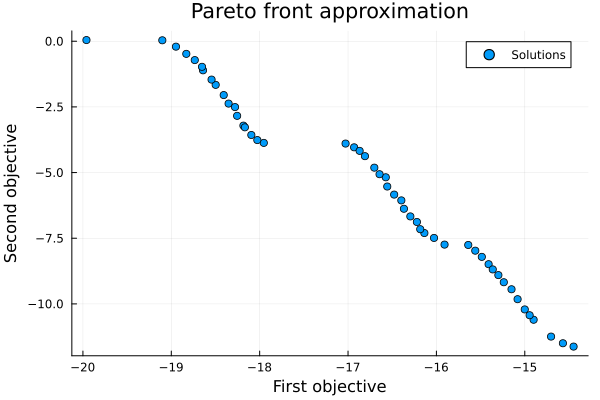

In [24]:
x = [solution.objectives[1] for solution in foundSolutions(nsgaII)];
y = [solution.objectives[2] for solution in foundSolutions(nsgaII)];
 
gr();
 
scatter(x, y,  title = "Pareto front approximation", label = "Solutions")
xlabel!("First objective")
ylabel!("Second objective")